Use google trends to compare google searches for COVID-19 Symptoms with Irish case numbers

In [2]:
!pip install pytrends

In [3]:
import pandas as pd
import io
import requests
from datetime import datetime, timedelta, date, time
import time
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
import matplotlib.pyplot as plt


In [4]:

def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df





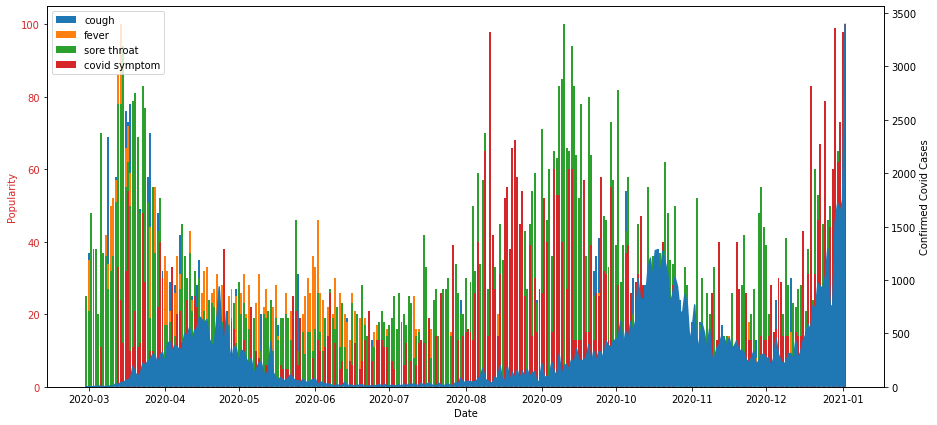

In [71]:
def get_covid_data():
  
    url = "https://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D"
    
    s = requests.get(url).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))
    # remove time
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    #cases = df[['Date', 'ConfirmedCovidCases', 'ConfirmedCovidDeaths']]
    return df
    

def plot_trends(term, cases_df):
    start_date = str(cases_df['Date'].min())
    end_date = str(cases_df['Date'].max())
    pytrends = TrendReq(hl='en-US', tz=0)
    for term in terms:
      df = get_daily_trend(pytrends, term, start_date, end_date, cat=0, geo='IE' )
      bar = ax1.bar(df.index, df[term])
      bar.set_label(term)
    ax1.legend(loc='upper left')





fig, ax1 = plt.subplots(figsize=(15, 7))
cases = get_covid_data()
terms = ['cough', 'fever', 'sore throat','covid symptom']
plot_trends(terms, cases)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Popularity', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylabel('Confirmed Covid Cases')  # we already handled the x-label with ax1
ax2.tick_params(axis='y')
ax2.plot(cases['Date'], cases['ConfirmedCovidCases'])
ax2.set_ylim(0)
ax2.fill_between(cases['Date'], 0, cases['ConfirmedCovidCases'], alpha=1)
plt.show()


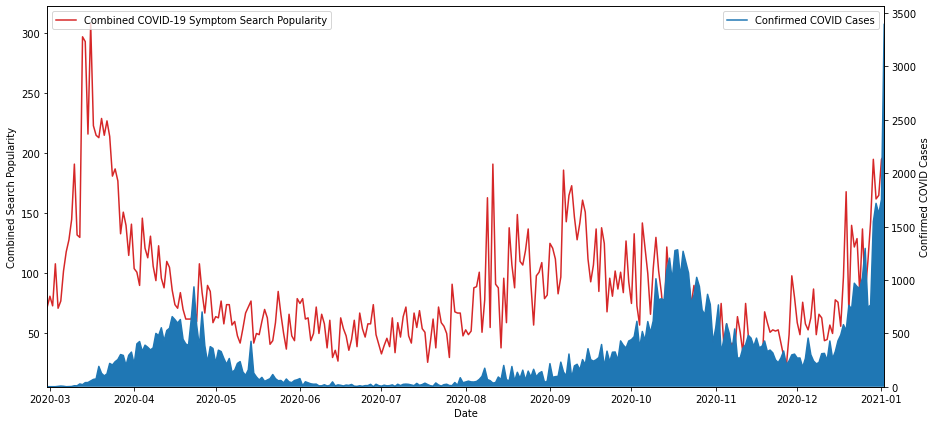

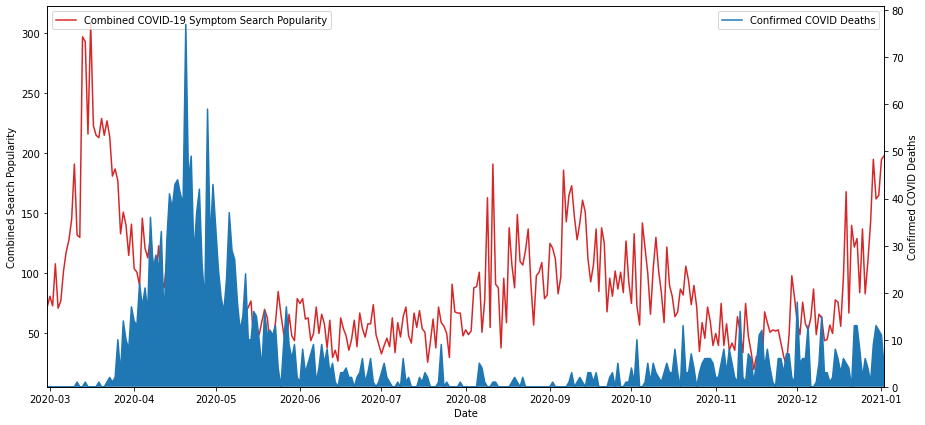

In [73]:
def combine_symptoms_cases(terms, cases_df):
    start_date = str(cases_df['Date'].min())
    end_date = str(cases_df['Date'].max())
    pytrends = TrendReq(hl='en-US', tz=0)
    term_dict = {}
    frames = []
    for term in terms:
      term_dict[term] = get_daily_trend(pytrends, term, start_date, end_date, cat=0, geo='IE' )
      frames.append(term_dict[term])
      del term_dict[term]['overlap']
      #print(term_dict[term].head())
    
    result = pd.concat(frames, axis=1, join="inner")
    
    #result.reset_index(level=0, inplace=True)
    #print(result)
    total_symptoms = result.sum(axis = 1, skipna = True)
    #print(total_symptoms)
    fig, ax1 = plt.subplots(figsize=(15, 7))
  
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Combined Search Popularity')
    ax1.tick_params(axis='y')
    ax1.plot(total_symptoms, color='tab:red', label='Combined COVID-19 Symptom Search Popularity')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Confirmed COVID Cases')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y')
    ax2.plot(cases['Date'], cases['ConfirmedCovidCases'], label='Confirmed COVID Cases')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0)
    ax2.set_xlim(cases_df['Date'].min(), cases_df['Date'].max())
    ax2.fill_between(cases['Date'], 0, cases['ConfirmedCovidCases'], alpha=1)
    plt.show()
    

def combine_symptoms_deaths(terms, cases_df):
    start_date = str(cases_df['Date'].min())
    end_date = str(cases_df['Date'].max())
    pytrends = TrendReq(hl='en-US', tz=0)
    term_dict = {}
    frames = []
    for term in terms:
      term_dict[term] = get_daily_trend(pytrends, term, start_date, end_date, cat=0, geo='IE' )
      frames.append(term_dict[term])
      del term_dict[term]['overlap']
      #print(term_dict[term].head())
    
    result = pd.concat(frames, axis=1, join="inner")
    
    #result.reset_index(level=0, inplace=True)
    #print(result)
    total_symptoms = result.sum(axis = 1, skipna = True)
    #print(total_symptoms)
    fig, ax1 = plt.subplots(figsize=(15, 7))
  
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Combined Search Popularity')
    ax1.tick_params(axis='y')
    ax1.plot(total_symptoms, color='tab:red', label='Combined COVID-19 Symptom Search Popularity')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Confirmed COVID Deaths')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y')
    ax2.plot(cases['Date'], cases['ConfirmedCovidDeaths'], label='Confirmed COVID Deaths')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0)
    ax2.set_xlim(cases_df['Date'].min(), cases_df['Date'].max())
    ax2.fill_between(cases['Date'], 0, cases['ConfirmedCovidDeaths'], alpha=1)
    plt.show()

combine_symptoms_cases(terms, cases)
combine_symptoms_deaths(terms, cases)




In [74]:
cases.tail()

,X,Y,Date,ConfirmedCovidCases,TotalConfirmedCovidCases,ConfirmedCovidDeaths,TotalCovidDeaths,StatisticsProfileDate,CovidCasesConfirmed,HospitalisedCovidCases,RequiringICUCovidCases,HealthcareWorkersCovidCases,ClustersNotified,HospitalisedAged5,HospitalisedAged5to14,HospitalisedAged15to24,HospitalisedAged25to34,HospitalisedAged35to44,HospitalisedAged45to54,HospitalisedAged55to64,HospitalisedAged65up,Male,Female,Unknown,Aged1,Aged1to4,Aged5to14,Aged15to24,Aged25to34,Aged35to44,Aged45to54,Aged55to64,Aged65up,Median_Age,CommunityTransmission,CloseContact,TravelAbroad,FID
302,-856335.869598,7.036492e+06,2020-12-29,1546,88439,9,2213,2020/12/27 00:00:00+00,86893.0,5898.0,666.0,13290.0,10615.0,60.0,61.0,215.0,373.0,465.0,729.0,844.0,3149.0,41237.0,45579.0,77.0,1429.0,1000.0,5971.0,15188.0,14794.0,13681.0,12969.0,9278.0,12553.0,38.0,32.0,64.0,1.0,303
303,-856335.869598,7.036492e+06,2020-12-30,1718,90157,13,2226,2020/12/28 00:00:00+00,88439.0,5932.0,671.0,13316.0,10623.0,60.0,63.0,217.0,375.0,468.0,739.0,846.0,3162.0,41998.0,46373.0,68.0,1468.0,1000.0,6084.0,15505.0,15120.0,13900.0,13176.0,9445.0,12711.0,38.0,32.0,63.0,1.0,304
304,-856335.869598,7.036492e+06,2020-12-31,1620,91779,12,2237,2020/12/29 00:00:00+00,90159.0,5987.0,673.0,13336.0,10648.0,61.0,63.0,219.0,379.0,469.0,744.0,855.0,3195.0,42852.0,47238.0,69.0,1507.0,1000.0,6172.0,15901.0,15461.0,14168.0,13421.0,9634.0,12844.0,38.0,32.0,63.0,1.0,305
305,-856335.869598,7.036492e+06,2021-01-01,1754,93532,11,2248,2020/12/30 00:00:00+00,91778.0,6038.0,678.0,13353.0,10695.0,61.0,63.0,223.0,392.0,473.0,747.0,857.0,3220.0,43646.0,48056.0,76.0,1539.0,1000.0,6248.0,16275.0,15812.0,14386.0,13650.0,9813.0,13024.0,38.0,33.0,62.0,1.0,306
306,-856335.869598,7.036492e+06,2021-01-02,3394,96926,4,2252,2020/12/31 00:00:00+00,93532.0,6087.0,679.0,13367.0,10736.0,61.0,63.0,230.0,396.0,478.0,756.0,863.0,3238.0,44492.0,48956.0,84.0,1574.0,1000.0,6337.0,16659.0,16179.0,14638.0,13888.0,10018.0,13208.0,38.0,33.0,60.0,1.0,307
